<a href="https://colab.research.google.com/github/B-Lorentz/riverine/blob/master/py/sph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jax import grad, vmap, jit, lax
from jax import numpy as jnp
from jax import random as rand
import jax
import functools as func
from dataclasses import dataclass

In [2]:
import pathlib
def once_in_a_VM(fname):
  pat = pathlib.Path(fname)
  if pat.exists():
      return False
  else:
    pat.mkdir()
    return True
if once_in_a_VM("download"):
  !git clone https://github.com/B-Lorentz/riverine.git

In [3]:
if once_in_a_VM("install"):
  !pip install -e riverine/py

In [4]:
from utils.height_field import *

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


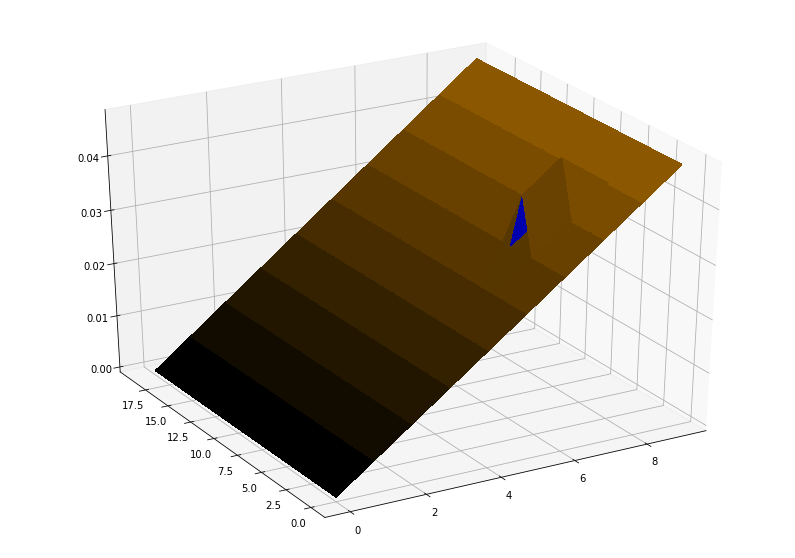

In [247]:

def show_terrain(b, d, threshold=1e-7):
  #print(d.shape, b.shape)
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 10))
  x, y = np.meshgrid(np.arange(b.shape[1]), np.arange(b.shape[0]))
  #print(x.shape, y.shape)
  color = np.array([0.0,0.0,0.9])*((d>threshold)*(0.1 + (b+d)/(b+d).max()))[:,:,np.newaxis] + np.array([0.8, 0.5, 0])*(b/b.max()*(d<threshold))[:,:,np.newaxis]

  ax.plot_wireframe(x, y, b, color="black")
  surf = ax.plot_surface(x, y, b+d, facecolors=color, antialiased=False, shade=True)
 
  return ax

h = tilt_hf(20, 0.1, 0.0)[:,:10]
w = np.zeros_like(h)+.0
w[4, 6] = 0.01 
w[4, 7] = 0.01 
ax = show_terrain(h, w)
ax.view_init(30, -120)

An eulerian 2D method using shallow-water equations:
Mei, Decaudin & Hu:
*Fast Hydraulic Erosion Simulation and Visualization on GPU*

-0.024142236
0.1218317
-0.058284283 0.020792685
(20, 10)
0.02 -3.7252903e-09


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


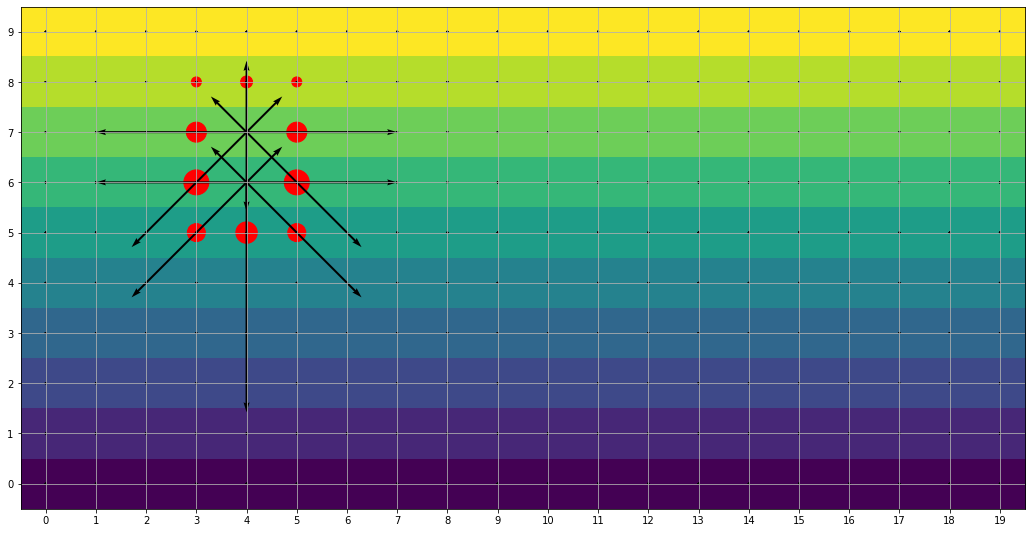

In [6]:
dirs = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
#dirs = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
def flow_init(h, dirs):
  return np.zeros((dirs.shape[0], *h.shape))

def flow_conv(h, dirs):
  kernel = np.zeros((dirs.shape[0], 1, 3, 3))
  for i, dir in enumerate(dirs):
    d = np.sqrt(np.power(dir, 2).sum())
    kernel[i, 0, 1, 1] += 1/d
    kernel[i, 0, 1+dir[0], 1+dir[1]] += -1/d
 
  res = lax.conv(h[np.newaxis,np.newaxis,:,:], kernel, (1,1),padding="VALID").squeeze()
 
  return jnp.pad(res, ((0,0), (1, 1), (1, 1)), mode="edge")

def collect_conv(f, dirs):
  kernel = np.zeros((1, dirs.shape[0], 3, 3))
  for i, dir in enumerate(dirs):
    kernel[0, i, 1, 1] += -1.0
    kernel[0, i, 1-dir[0], 1-dir[1]] += 1.0
  
  res = lax.conv(jnp.pad(f, ((0,0),(1, 1), (1, 1)), mode="edge")[np.newaxis,:,:,:], kernel, (1,1),padding="VALID", precision=lax.Precision.HIGHEST).squeeze()
  return res

def f_scale(f, w, dt):
  f = jnp.maximum(f, 0.0)
  return f*jnp.minimum(1.0, w/(dt * (f.sum(0) + 1e-9)))

def flow_quiver(h, w, f, markers = ([], [])):
  plt.figure(figsize=(18, 10))
  x, y = np.meshgrid(np.arange(h.shape[-2]), np.arange(h.shape[-1]))
 
  plt.imshow(h.T, origin="lower", )
  plt.scatter(x.T, y.T, s=3000*w, c="r")
  plt.scatter(markers[0], markers[1], s=100, marker="x" )
  plt.gca().xaxis.set_major_locator(MultipleLocator(1))
  plt.gca().yaxis.set_major_locator(MultipleLocator(1))
  plt.grid()
  print(h.shape)
  for dir, f_ in zip(dirs, f):
    d = np.sqrt(np.power(dir, 2).sum())
    plt.quiver(x.T, y.T, dir[0]*f_/d, dir[1]*f_/d, scale=1, units="xy", width=0.04, headlength=5)
 
 
f = flow_init(h, dirs)
f[1] = 1.0
f = flow_conv(h + w, dirs)
#print(f[2])
print(f.sum())
f = f_scale(f, w, 0.1)
print(f.sum())
w1 = collect_conv(f, dirs)
print(w1.min(), w1.max())
flow_quiver(h, 10*(w+w1), f*300)
print(w.sum(), w1.sum())

(20, 10)


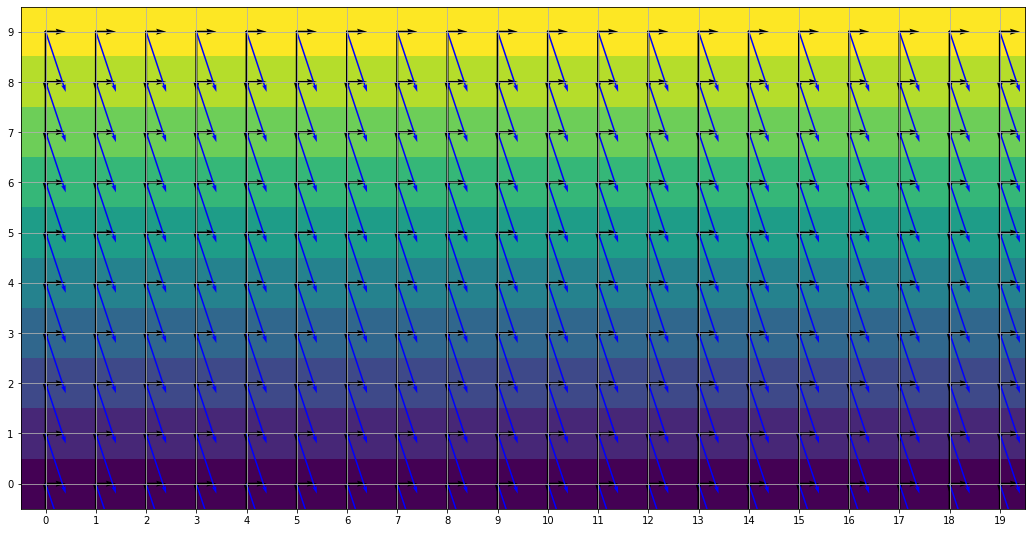

In [275]:
def v_conv(f, dirs):
  kernel = np.zeros((2, dirs.shape[0], 3, 3))
  bvs = np.array(((1, 0), (0, 1.0)))
  for i, dir in enumerate(dirs):
    dot = (bvs*dir).sum(-1)/(dir**2).sum()
   
    kernel[:, i, 1, 1] += 0.5*dot
    kernel[:, i, 1+dir[0], 1+dir[1]] += 0.5*dot
  res = lax.conv(jnp.pad(f, ((0, 0), (1, 1), (1, 1)), mode="edge")[np.newaxis,:,:], kernel, (1,1),padding="VALID").squeeze()
  return res

def vector_quiver(vs, **kwargs):
  x, y = np.meshgrid(np.arange(vs.shape[-2]), np.arange(vs.shape[-1]))
  plt.quiver(x.T, y.T, vs[0], vs[1], **kwargs)
ftest = flow_init(h, dirs)
ftest[0,:,:] = 0.1
ftest[6,:,:] = 0.3
vs = v_conv(ftest, dirs)
flow_quiver(h, 0, 4*ftest)
vector_quiver(4*vs, scale=1, units="xy", width=0.03, headlength=5, color="blue")

In [344]:

def make_update(source, dt, dirs, gA, nu, K_evap, K_carry, K_dis, K_depo, logger=lambda h, w, f, s, dh, dw: None, wofset=1.0):
  l = np.sqrt(np.power(dirs, 2).sum(-1))
  def update(h, w, f, s):
    # Source term
    w = w + source*dt
    # Flow update
    tilt = jnp.abs(flow_conv(h, dirs)).max(0)
    df = gA*flow_conv(h+w, dirs) - nu*f/(w+wofset)*(1+tilt)
    f = f + dt*df
    f = f_scale(f, w, dt)
    dw = collect_conv(f, dirs)*dt
    w = w + dw
    wv = v_conv(f, dirs)
    # Sediment carry
    
    C_s = K_carry*jnp.sqrt((wv**2).sum(0)) - s
    erodes = (C_s>0)
    dh =  (erodes*K_dis + (~erodes)*K_depo )*(C_s) *dt
    h = h - dh
    s = s + dh
    
    # Sediment transport
    fs = f_scale(f*s, s, dt)
    s = s + collect_conv(fs, dirs)*dt
    s = jnp.maximum(s, 0)

    # Evaporation
    w = w*(1- K_evap*dt)

    return h, w, f, s, logger(h, w, f, s, dh, dw)
  return update

In [345]:

def trace_sim(update, h, w, N):
  s = np.zeros_like(h)
  f = flow_init(h, dirs)
  
  def upd(state, _):
    h, w, f, s, log= update(*state)
    return (h, w, f, s), log
  end, log = jax.lax.scan(jit(upd), (h, w, f, s), xs=None, length=N)
  return end, log 


def for_sim(update, h, w, N):
  s = np.zeros_like(h)
  f = flow_init(h, dirs)
  
  def upd(i, state):
    h, w, f, s, log= update(*state)
    return (h, w, f, s)
  end = jax.lax.fori_loop(0, N, jit(upd), (h, w, f, s))
  return end

In [224]:
res, log = trace_sim(make_update(0, 0.05, dirs, 9.81, 0.1, 
                                        K_evap=0.01, K_carry=0.0, K_dis=0.0, K_depo=0.0, logger=lambda h, w, f, s, dh, dw: w), h, w, 100)

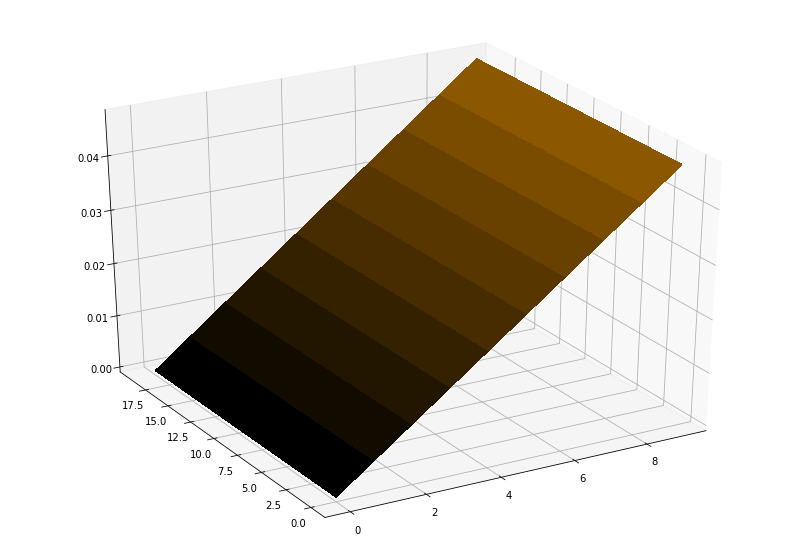

In [227]:
ax = show_terrain(h, log[200])
ax.view_init(30, -120)

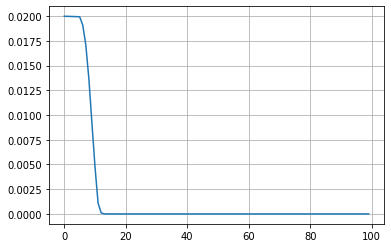

In [228]:
plt.plot(log.sum(-1).sum(-1))
plt.grid()

In [251]:
def basin_experiment():
  N = 100
  h1 = basin_hf(N)
  w1 = np.maximum(tilt_hf(N, 0.1, 0.1)+0.2-h1,0)

 
  res, log = trace_sim(make_update(0, 0.1, dirs, gA=9.81, nu=0.1,K_evap=0.01, 
                                        K_carry= 0.0, K_dis= 0.0, K_depo=0.0,
                                        logger=lambda h, w, f, s, dh, dw: w), h1, w1, 1000)

  
  return h1, w1, res, log

def basin_plot(result):
  h1, w1, res, log = result
  ax = show_terrain(h1, w1)
  ax.view_init(20, 120)
  ax = show_terrain(h1, log[-1])
  ax.view_init(20, 120)
  
  plt.figure(figsize=(8, 4))
  plt.plot(log[:, 70, 70])
  plt.grid()
 
  plt.xlabel("t", fontsize=14)
  plt.ylabel("water level", fontsize=14)
res = basin_experiment()

In [248]:
res = basin_experiment()

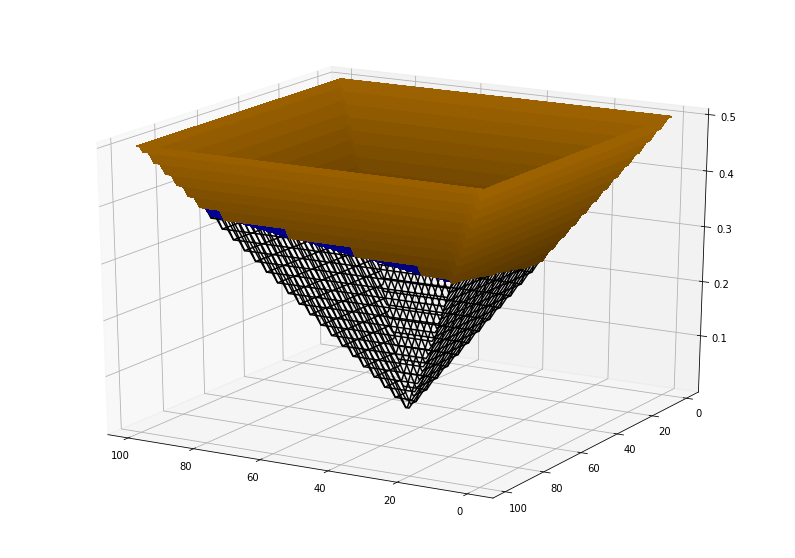

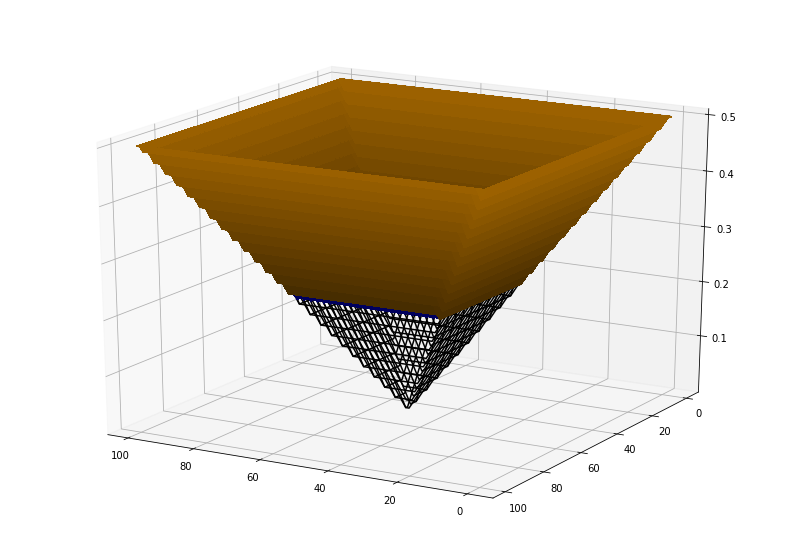

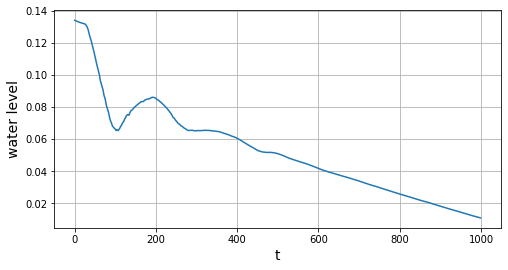

In [252]:
basin_plot(res)

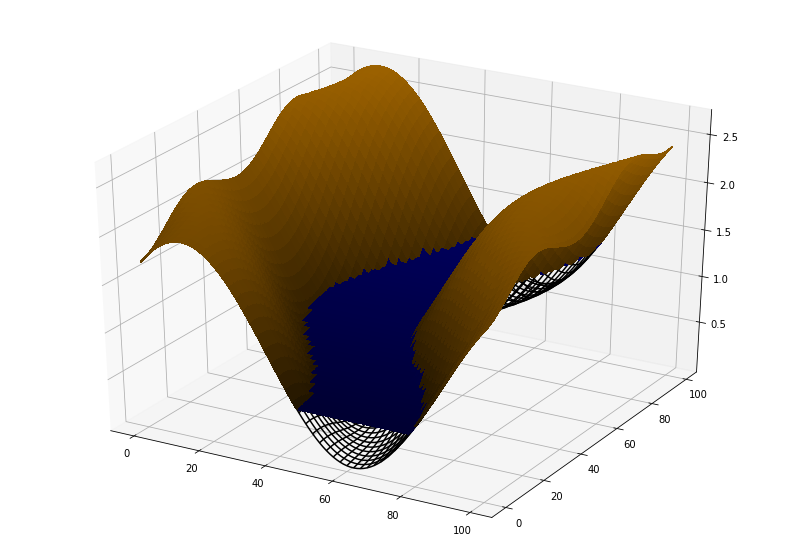

In [362]:
def wavy_field(N):
  h = sine_hf(N, 1.0, 0.25)
  #h[-5:,:] += 1.0
  w = np.zeros((N, N))
  w += np.maximum(0.5-h, 0)
  return h+tilt_hf(N, 0.0, 0.7), w
def wavy_channel_experiment(wf):
  h, w = wf
  source = np.zeros(w.shape)
  #source[-1,:] += 1.0*(w[-1,:]>0.001)*w[-1,:]
  res = for_sim(make_update(source, 0.1, dirs, gA=9.81, nu=0.1, K_evap=0.001, 
                                        K_carry= 0.4, K_dis= 0.01, K_depo=0.0, wofset=0.001), h, w, 5000)
  return h, w, source, res

wf = wavy_field(100)
show_terrain(wf[0], wf[1])

In [363]:
res = wavy_channel_experiment(wf)

(2, 100, 100)


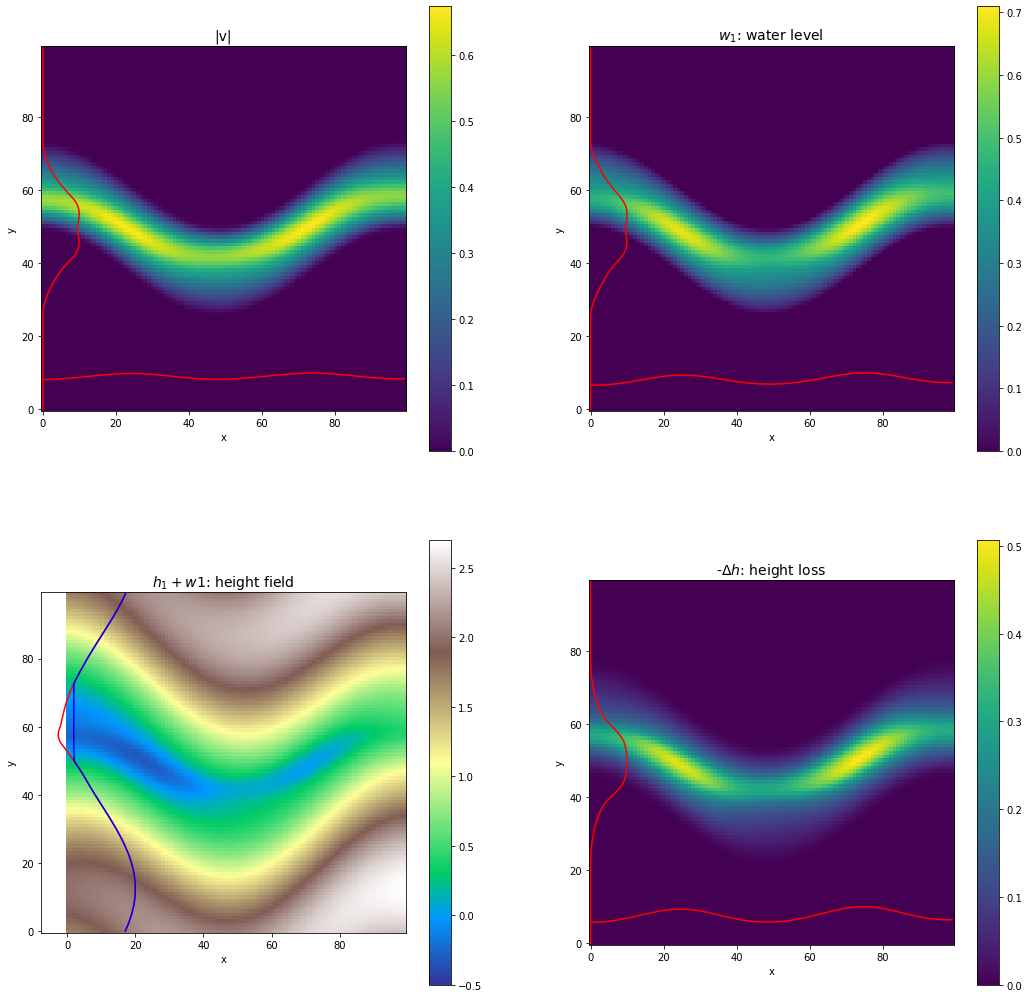

In [365]:
def plot_v(f, name, **kwargs):
  plt.imshow(f.T, origin="lower", **kwargs)
  plt.title(name, fontsize=14)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()


def before_after(res):
  
  h, w, source, (h1, w1, f, s) = res
  N = h1.shape[0]

  def plot_marginals(w):
    norm = lambda q: q/q.max()*10
    plt.plot(norm(w.sum(0)), np.arange(N), "r")
    plt.plot(norm(w.sum(-1)), "r")

  plt.figure(figsize=(18, 18))
  

  plt.subplot(221)
  v = v_conv(f, dirs)
  print(v.shape)
  #vector_quiver(1.0*v, color="black", units="xy", scale=0.5, headlength=1)
  vabs = np.sqrt((v**2).sum(0))
  plot_v(vabs, "|v|")
  plot_marginals(vabs)

  plt.subplot(222)
  plot_v(w1, r"$w_1$: water level")
  plot_marginals(w1)

  plt.subplot(223)
  plot_v(h1, r"$h_1 + w1$: height field ", cmap="terrain", vmin = -0.5)
  plt.plot(10*h1[0,:],np.arange(N), "r")
  plt.plot(10*(h1[0,:]+w1[0,:]),np.arange(N), "b")

  plt.subplot(224)
  dh = h-h1
  plot_v(dh, r"-$\Delta h$: height loss")
  
  plot_marginals(dh)

before_after(res)

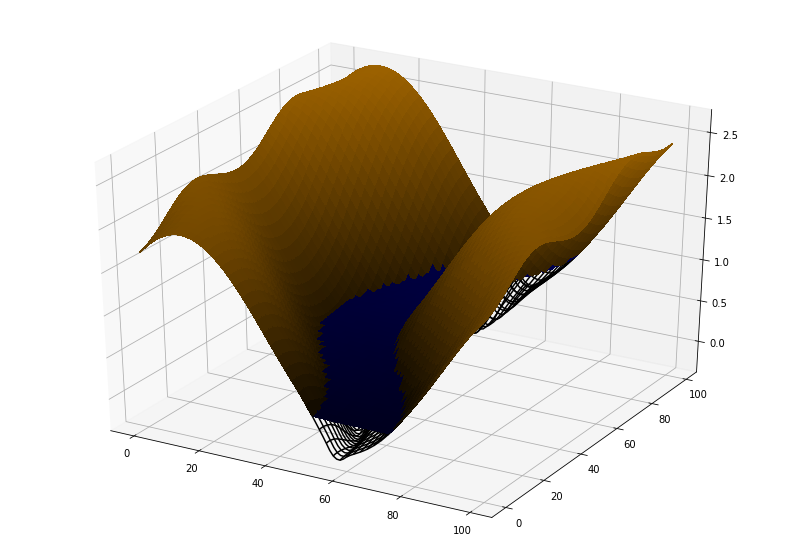

In [366]:
show_terrain(res[3][0], res[3][1])